In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import cg

import jlinops
import sampi

# Transformed regularized least-squares

# Type 1, R is invertible.

In [2]:
def trlstsq_rinv(A, Rinv, b, lam=1.0, *args, **kwargs):
    """Solves the regularized least-squares problem
    min_x || A x - b ||_2^2 + lam*|| R x ||_2^2
    using a transformation to standard form + a CGLS method. 
    It is assumed that null(A) and null(R) intersect trivially,
    and additionally that R is square invertible.
    """
    # Build Atilde
    device = A.device
    xp = jlinops.device_to_module(device)
    n = A.shape[1]
    
    Atilde = A @ Rinv 
    data = jlinops.rlstsq(Atilde, b, lam=lam, *args, **kwargs)
    
    # Transform solution and overwrite cgls_data
    data["z"] = data["x"].copy() # z is new coordinate
    x = Rinv @ data["x"]
    data["x"] = x
    
    return data

In [19]:
n = 100
A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=4)
#A = jlinops.IdentityOperator((n,n))
Rmat, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
R = jlinops.MatrixLinearOperator(Rmat)
b = A.matvec(np.cumsum(np.random.normal(size=n)))
Rinv = jlinops.MatrixLinearOperator(np.linalg.inv(Rmat.toarray()))

In [20]:
lam = 1e1

data_trlstsq_rinv = trlstsq_rinv(A, Rinv, b, lam=lam, tol=1e-3)
data_trlstsq = jlinops.trlstsq(A, R, b, lam=lam, tol=1e-3)

Q = (A.T @ A) + lam*(R.T @ R)
scipy_cg_sol, _ = cg(Q, A.T @ b, tol=1e-4, x0=np.ones(n))

In [21]:
print(np.linalg.norm(data_trlstsq["x"] - scipy_cg_sol))

0.008201254391989545


In [22]:
print(np.linalg.norm(data_trlstsq_rinv["x"] - scipy_cg_sol))

0.002064127221395356


In [23]:
print(np.linalg.norm(data_trlstsq_rinv["x"] - data_trlstsq["x"] ))

0.008698458703686343


In [24]:
data_trlstsq_rinv["converged"]

True

In [25]:
data_trlstsq["converged"]

True

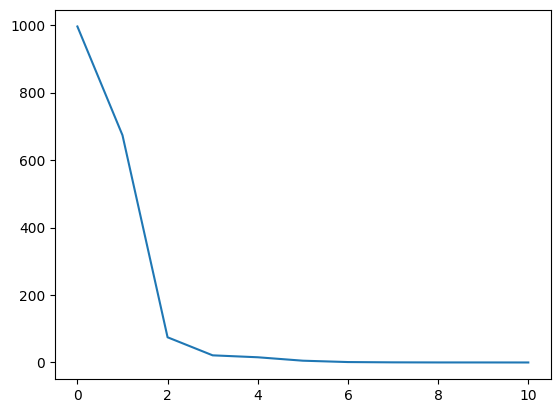

In [26]:
plt.plot(data_trlstsq_rinv["At_residual_norms"])
plt.show()

# R noninvertible but with trivial kernel

In [31]:
from scipy.linalg import null_space

In [38]:
def trlstsq_rtker(A, Rpinv, b, lam=1.0, chol_fac=False, *args, **kwargs):
    """Solves the regularized least-squares problem
    min_x || A x - b ||_2^2 + lam*|| R x ||_2^2
    using a transformation to standard form + a CGLS method. 
    It is assumed that null(A) and null(R) intersect trivially,
    and additionally that R has a trivial kernel (but possibly
    non-square).
    
    If chol_fac=False, Rpinv should represent the MP pseudoinverse.
    If chol_fac=True, Rpinv should represent square L^-T where R^T R = L L^T.
    """
    # Build Atilde
    device = A.device
    xp = jlinops.device_to_module(device)
    n = A.shape[1]
    
    Atilde = A @ Rpinv 
    data = jlinops.rlstsq(Atilde, b, lam=lam, *args, **kwargs)
    
    # Transform solution and overwrite cgls_data
    data["z"] = data["x"].copy() # z is new coordinate
    x = Rpinv @ data["x"]
    data["x"] = x
    
    return data

In [95]:
n = 25
A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=4)
#A = jlinops.IdentityOperator((n,n))
Rmat, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
Rmat = Rmat.toarray()
Rmat = np.vstack([Rmat, Rmat])
# Rmat = Rmat.T @ Rmat
R = jlinops.MatrixLinearOperator(Rmat)
Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(Rmat))
b = A.matvec(np.cumsum(np.random.normal(size=n)))

In [96]:
lam = 1e1

#data_trlstsq_rinv = trlstsq_rinv(A, Rinv, b, lam=lam, tol=1e-3)
data_trlstsq = jlinops.trlstsq(A, R, b, lam=lam, tol=1e-3)
data_trlstsq_rtker = trlstsq_rtker(A, Rpinv, b, lam=lam, tol=1e-3)

Q = (A.T @ A) + lam*(R.T @ R)
scipy_cg_sol, _ = cg(Q, A.T @ b, tol=1e-3)

In [97]:
print(np.linalg.norm(data_trlstsq_rtker["x"] - scipy_cg_sol))

0.0004443350182862952


In [98]:
print(np.linalg.norm(data_trlstsq["x"] - scipy_cg_sol))

2.927390968173784e-15


In [99]:
print(np.linalg.norm(data_trlstsq["x"] - data_trlstsq_rtker["x"]))

0.0004443350182866868


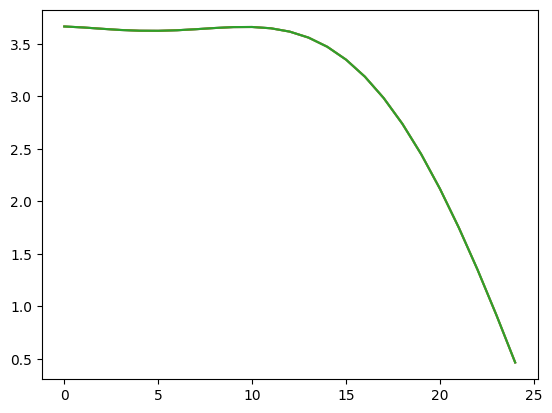

In [100]:
plt.plot(data_trlstsq["x"])
plt.plot(data_trlstsq_rtker["x"])
plt.plot(scipy_cg_sol)
plt.show()

In [101]:
n = 25
A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=4)
#A = jlinops.IdentityOperator((n,n))
Rmat, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
Rmat = Rmat.toarray()
Rmat = np.vstack([Rmat, Rmat])
R = jlinops.MatrixLinearOperator(Rmat)
RtRchol = np.linalg.cholesky(Rmat.T @ Rmat)
Linv = np.linalg.inv(RtRchol)
Linv = jlinops.MatrixLinearOperator(Linv)
b = A.matvec(np.cumsum(np.random.normal(size=n)))

In [102]:
lam = 1e1

#data_trlstsq_rinv = trlstsq_rinv(A, Rinv, b, lam=lam, tol=1e-3)
data_trlstsq = jlinops.trlstsq(A, R, b, lam=lam, tol=1e-3)
data_trlstsq_rtker = trlstsq_rtker(A, Linv.T, b, lam=lam, tol=1e-3)

Q = (A.T @ A) + lam*(R.T @ R)
scipy_cg_sol, _ = cg(Q, A.T @ b, tol=1e-3)

In [103]:
print(np.linalg.norm(data_trlstsq_rtker["x"] - scipy_cg_sol))

0.0010298243759140902


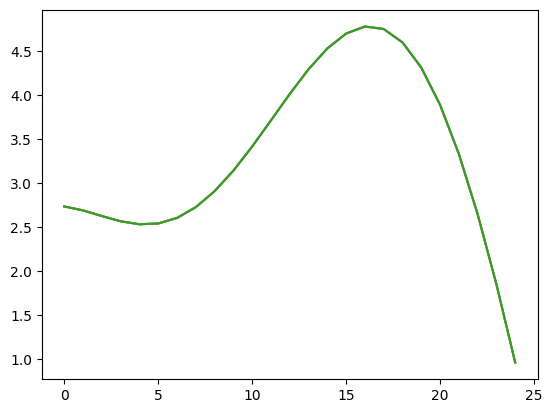

In [104]:
plt.plot(data_trlstsq["x"])
plt.plot(data_trlstsq_rtker["x"])
plt.plot(scipy_cg_sol)
plt.show()

### Which has better condition number?

In [105]:
Q1 = Rpinv.T @ ( A.T @ ( A @ Rpinv )) + jlinops.IdentityOperator( (Rpinv.shape[1], Rpinv.shape[1]) )
Q2 =  Linv @ ( A.T @ ( A @ Linv.T )) + jlinops.IdentityOperator( (Linv.shape[1], Linv.shape[1]) )

In [106]:
Q1mat = jlinops.black_box_to_dense(Q1)
Q2mat = jlinops.black_box_to_dense(Q2)

In [107]:
Q1mat.shape

(50, 50)

In [108]:
Q2mat.shape

(25, 25)

In [109]:
np.linalg.cond(Q1mat)

116.20807752092735

In [110]:
np.linalg.cond(Q2mat)

116.20807751979635

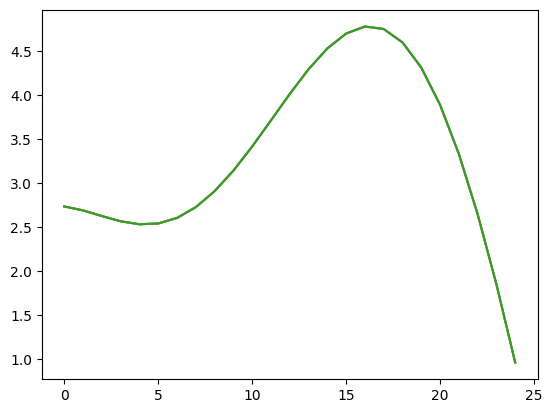

In [111]:
plt.plot(data_trlstsq["x"])
plt.plot(data_trlstsq_rtker["x"])
plt.plot(scipy_cg_sol)
plt.show()

# Oblique method for nontrivial kernel

In [113]:
from scipy.linalg import null_space

In [141]:
def trlstsq_rntker(A, Rpinv, W, b, lam=1.0, AWpinv=None, chol_fac=False, *args, **kwargs):
    """Solves the regularized least-squares problem
    min_x || A x - b ||_2^2 + lam*|| R x ||_2^2
    using a transformation to standard form + a CGLS method. 
    It is assumed that null(A) and null(R) intersect trivially,
    and additionally that R has a nontrivial kernel.
    
    W should be a MatrixLinearOperator whose columns span null(R).
    """
    # Build Atilde
    device = A.device
    xp = jlinops.device_to_module(device)
    n = A.shape[1]
    
    # Build oblique pseudoinverse
    if AWpinv is None:
        AWpinv = jlinops.QRPinvOperator( A.matmat(W.A) )
    oblique_pinv = ( jlinops.IdentityOperator((n,n)) -  W @ (AWpinv @ A)  ) @ Rpinv
    
    # Get contribution from kernel
    x_null = W @ (AWpinv @ b)
    
    # Get contribution from complement
    Atilde = A @ oblique_pinv
    data = jlinops.rlstsq(Atilde, b, lam=lam, *args, **kwargs)
    
    # Transform solution and overwrite cgls_data
    data["z"] = data["x"].copy() # z is transformed coordinate
    data["x_null"] = x_null
    x_null_comp = oblique_pinv @ data["x"]
    data["x_null_comp"] = x_null_comp
    x = x_null_comp + x_null
    data["x"] = x
    data["oblique_pinv"] = oblique_pinv
    
    return data

In [190]:
n = 25
A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=4)
#A = jlinops.IdentityOperator((n,n))
Rmat, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
Rmat = Rmat.toarray()
rows_to_drop = [10, 15]
Rmat = np.delete(Rmat, rows_to_drop, axis=0)
Wmat = null_space(Rmat)
R = jlinops.MatrixLinearOperator(Rmat)
W = jlinops.MatrixLinearOperator(Wmat)
# R = jlinops.MatrixLinearOperator(Rmat)
# RtRchol = np.linalg.cholesky(Rmat.T @ Rmat)
# Linv = np.linalg.inv(RtRchol)
# Linv = jlinops.MatrixLinearOperator(Linv)
b = A.matvec(np.cumsum(np.random.normal(size=n)))

In [198]:
# Build oblique pseudoinverse
Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(Rmat))
# AWpinv = jlinops.QRPinvOperator( A.matmat(Wmat) )
# obl_op = ( jlinops.IdentityOperator((n,n)) -  W @ (AWpinv @ A)  ) @ Rpinv

In [199]:
lam = 1e0

#data_trlstsq_rinv = trlstsq_rinv(A, Rinv, b, lam=lam, tol=1e-3)
data_trlstsq = jlinops.trlstsq(A, R, b, lam=lam, tol=1e-3)
data_trlstsq_rntker = trlstsq_rntker(A, Rpinv, W, b, lam=lam, tol=1e-8)

Q = (A.T @ A) + lam*(R.T @ R)
scipy_cg_sol, _ = cg(Q, A.T @ b, tol=1e-3)

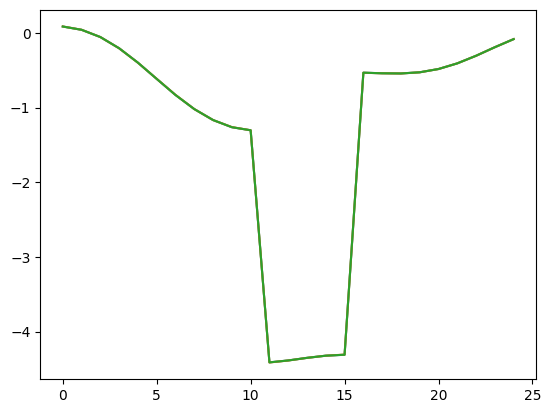

In [200]:
plt.plot(data_trlstsq["x"])
plt.plot(data_trlstsq_rntker["x"])
plt.plot(scipy_cg_sol)
plt.show()

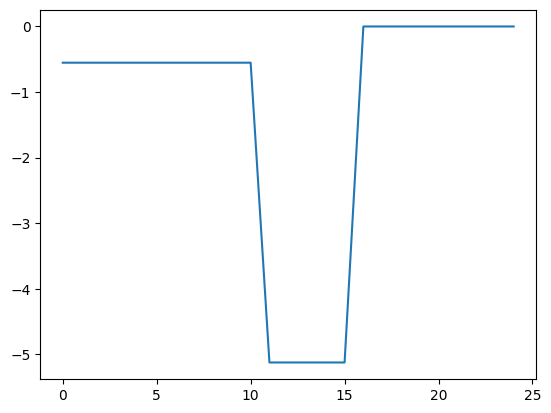

In [201]:
plt.plot(data_trlstsq_rntker["x_null"])
plt.show()

In [202]:
Qmat = jlinops.black_box_to_dense(Q)
print(np.linalg.cond(Qmat))

88.1039684784181


In [204]:
O = jlinops.black_box_to_dense(data_trlstsq_rntker["oblique_pinv"])

In [206]:
Otilde = (O.T @ O) + np.eye(O.shape[1])

In [207]:
print(np.linalg.cond(Otilde))

46.384645811908044
